## Assignment 7

The goal of this lab is to introduce the basic models used to simulate epidemics in networks, experiment with them and compare them. 
We will explore both types of diffusion models, decision-based and epidemic ones.
As a use case, we are going to use the coauthorship network of network scientists, which you can load with the function read gml from networkx library.

The following questions can be answered with the help of networkx and NDlib. You may also use other packages to deal with the problem. Please answer the following
questions on the networks you have and submit your executable code.

In [63]:
import networkx as nx
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ndlib.models.ModelConfig as mc
import ndlib.models.opinions as op
import ndlib.models.epidemics as ep

In [5]:
path = "data/"
gml_path = path + "netscience.gml"

In [ ]:
# download a file from a url 
def download(url,file_name):
    get_response = requests.get(url)
    with open(file_name, "wb") as out_file:
        out_file.write(get_response.content)

download(url="http://www.casos.cs.cmu.edu/computational_tools/datasets/external/netscience/netscience.gml", file_name=gml_path)

Graph with 1589 nodes and 2742 edges
Is the graph directed? False
Is the graph connected? False
Number of connected components: 396
Average degree: 3.45
Graph density: 0.00217
Average clustering coefficient: 0.64


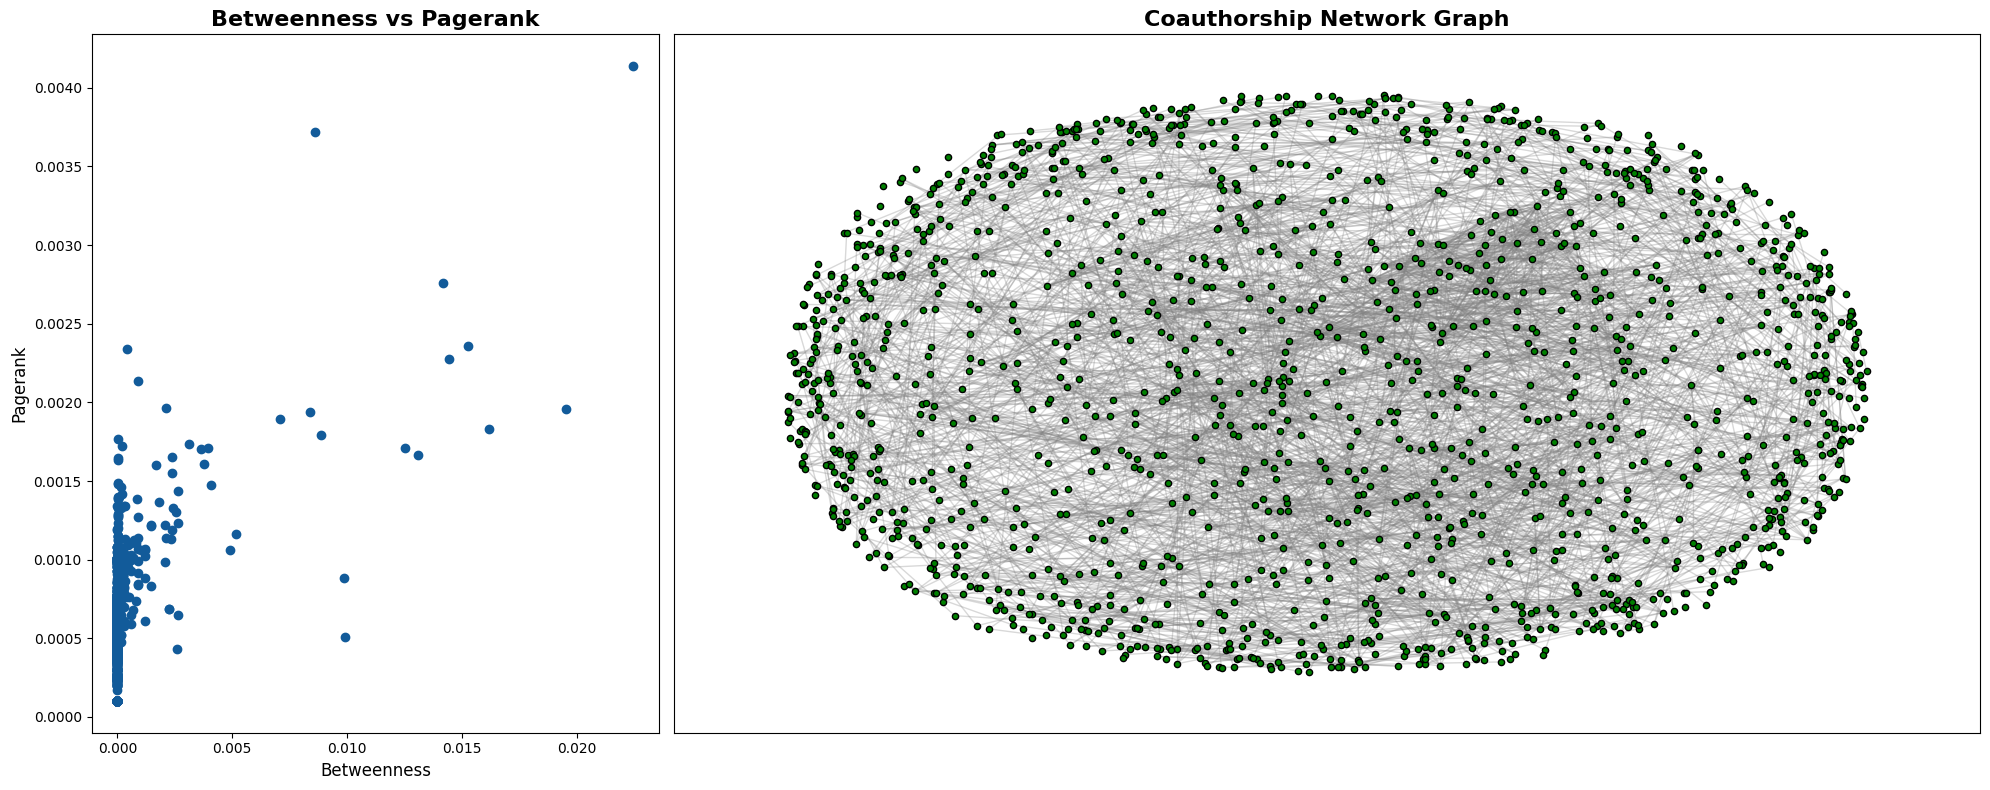

In [31]:
# Read the data
G = nx.read_gml(gml_path)
# Show the basic information about the graph
print(G)
# Check if the graph is directed or undirected
print(f"Is the graph directed? {nx.is_directed(G)}")
# Check if the graph is connected (only for undirected graphs)
if not nx.is_directed(G):
    print(f"Is the graph connected? {nx.is_connected(G)}")
    print(f"Number of connected components: {nx.number_connected_components(G)}")
else:
    print(f"Is the graph strongly connected? {nx.is_strongly_connected(G)}")
    print(f"Is the graph weakly connected? {nx.is_weakly_connected(G)}")
# Average degree
degree_dict = dict(G.degree())
avg_degree = sum(degree_dict.values()) / G.number_of_nodes()
print(f"Average degree: {round(avg_degree, 2)}")
# Density
density = nx.density(G)
print(f"Graph density: {round(density, 5)}")
# Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {round(avg_clustering, 2)}")
# Betweenness
betweenness = nx.betweenness_centrality(G=G, normalized=True)
# Pagerank
pagerank = nx.pagerank(G=G, alpha=0.85)
# Plot betweenness & pagerank & graph
def plot_betweenness_pagerank_graph(G: nx.Graph, betweenness: dict, pagerank: dict) -> None:
    """
    Plots Betweenness Closeness and PageRank values assossiated with the same nodes.

    Parameters:
        - G (nx.Graph): Input graph.
        - betweenness (dict): Betweenness closeness values.
        - pagerank (dict): Pagerank scores.
    """
    # get node ids
    common_keys = list(set(betweenness.keys()).intersection(set(pagerank.keys())))
    # extract values corresponding to the same nodes
    betweenness_values = [betweenness[k] for k in common_keys]
    pagerank_values = [pagerank[k] for k in common_keys]
    # plot
    fig = plt.figure(figsize=(20, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.3])
    # betweenness & pagerank
    ax1 = fig.add_subplot(gs[0])
    ax1.scatter(betweenness_values, pagerank_values, color="#125b9a")
    ax1.set_xlabel("Betweenness", fontsize=12)
    ax1.set_ylabel("Pagerank", fontsize=12)
    ax1.set_title("Betweenness vs Pagerank", fontsize=16, fontweight="bold")
    # graph
    ax2 = fig.add_subplot(gs[1])
    pos = nx.spring_layout(G, k=0.4, seed=1)
    nx.draw_networkx_nodes(G, pos, node_color="green", node_size=20, edgecolors="black", linewidths=1, ax=ax2)
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.3, ax=ax2)
    ax2.set_title("Coauthorship Network Graph", fontsize=16, fontweight="bold")
    # show
    plt.tight_layout()
    plt.show()
plot_betweenness_pagerank_graph(G=G, betweenness=betweenness, pagerank=pagerank)

**(a)** The Sznajd model is a variant of spin model based on social impact, which
takes into account the fact that a group of individuals with the same opinion can influence their
neighbours more than one single individual. Please use the Sznajd model to simulate the cascade
of misinformation between the network of network scientists for 100 steps with different initial ”infected” numbers: 100, 300, and 700. Please visualize the results and output a prevalence plot. (May refer to NDlib.)

In [89]:
def plot_diffusion_trend_and_prevalence(trends, num_iterations, total_nodes):
    # Initialize lists to track the number and fraction of nodes with each opinion
    pos_counts = trends[0]['trends']['node_count'][0]  # Get count of +1 opinions or 0 if missing
    neg_counts = trends[0]['trends']['node_count'][1]  # Get count of -1 opinions or 0 if missing

    # Store fractions (for prevalence)
    pos_opinion_prevalence = [ i / total_nodes for i in pos_counts]
    neg_opinion_prevalence = [ i / total_nodes for i in neg_counts]

    # Create a figure with two subplots: one for Trend and one for Prevalence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Diffusion Trend (absolute pos_count)
    ax1.plot(range(num_iterations), pos_counts, label="Positive Opinion (+1)", color='blue')
    ax1.plot(range(num_iterations), neg_counts, label="Negative Opinion (-1)", color='red')
    ax1.set_xlabel('Iterations', fontsize=12)
    ax1.set_ylabel('Number of Nodes', fontsize=12)
    ax1.set_title('Diffusion Trend: Opinion Dynamics', fontsize=16, fontweight="bold")
    ax1.legend()

    # Plot Diffusion Prevalence (fractions)
    ax2.plot(range(num_iterations), pos_opinion_prevalence, label="Positive Opinion (+1)", color='blue')
    ax2.plot(range(num_iterations), neg_opinion_prevalence, label="Negative Opinion (-1)", color='red')
    ax2.set_xlabel('Iterations', fontsize=12)
    ax2.set_ylabel('Prevalence (Fraction of Nodes)', fontsize=12)
    ax2.set_title('Diffusion Prevalence: Opinion Dynamics', fontsize=16, fontweight="bold")
    ax2.legend()

    # Show the combined plot
    plt.tight_layout()
    plt.show()


In [90]:
def sznajd_model(G, initial_infected_number, number_iterations):
    """
    Simulate sznajd model and plot the results.
    Parameters:
        - G: networkx graph
        - initial_infected_rate: initial infected rate
        - number_iterations: hyper-parameter may play with
    """
    # Remove isolated nodes, since in the Sznajd model, nodes interact with their neighbors. 
    #   If a node has no neighbors (e.g., isolated nodes in the graph), 
    #   attempting to randomly select a neighbor causes an error.
    if len(list(nx.isolates(G))) > 0:
        print(f"Removing {len(list(nx.isolates(G)))} isolated nodes.")
        G.remove_nodes_from(list(nx.isolates(G)))
    # Total number of nodes
    total_nodes = len(G.nodes)
    # Initial infected rate since we have to provide it as a value between (0, 1)
    initial_infected_rate = initial_infected_number / total_nodes

    # Model selection
    model = op.SznajdModel(G)
    config = mc.Configuration()
    config.add_model_parameter("fraction_infected", initial_infected_rate)
    model.set_initial_status(config)
    # Simulation execution
    iterations = model.iteration_bunch(number_iterations)
    trends = model.build_trends(iterations)
    
    # Visualize the result
    plot_diffusion_trend_and_prevalence(trends=trends, num_iterations=number_iterations, total_nodes=total_nodes)

In [91]:
num_iterations = 100

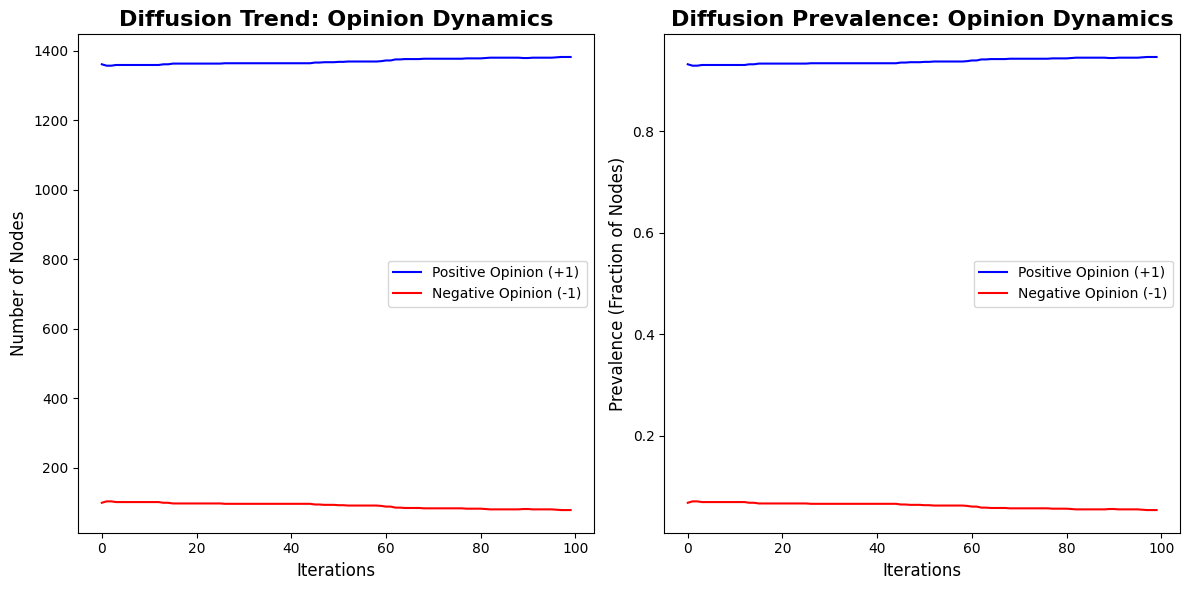

In [92]:
# Run sznajd for initial infected number: 100
sznajd_model(G=G, initial_infected_number=100, number_iterations=num_iterations)

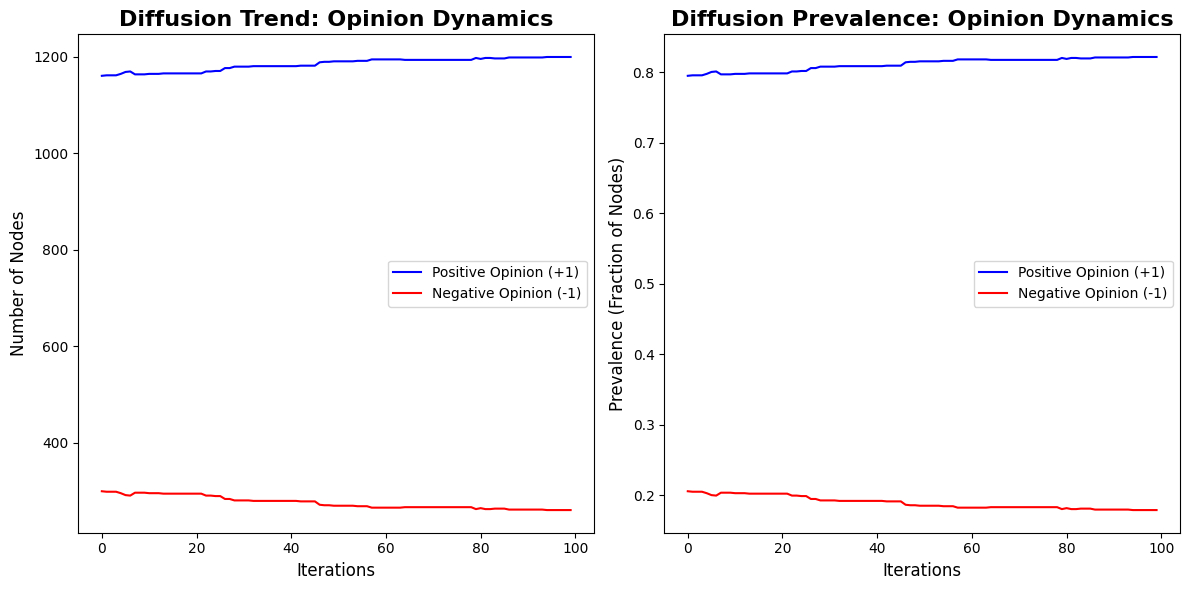

In [93]:
# Run sznajd for initial infected number: 300
sznajd_model(G=G, initial_infected_number=300, number_iterations=num_iterations)

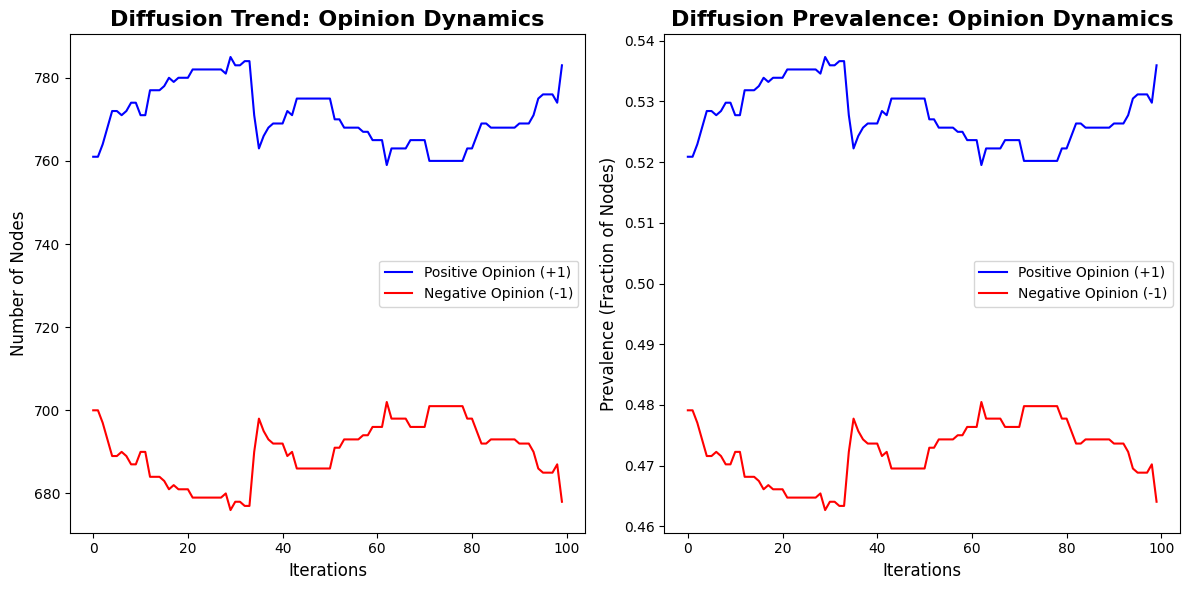

In [94]:
# Run sznajd for initial infected number: 700
sznajd_model(G=G, initial_infected_number=700, number_iterations=num_iterations)

**(b)** Although the interaction networks in real-life are different from the social networks we have, it is still meaningful to simulate the epidemics cascade with our dataset. The SIR model was introduced in 1927 by Kermack. In this model, during the course of an epidemic, a node is allowed to change its status from Susceptible (S) to Infected (I), then to Removed (R). Please use the SIR model to simulate for 100 iterations the cascade of the epidemic with the following three sets of infection/removal probabilities: (0.5, 0.2), (0.3, 0.3), (0.4, 0.5) on the network science dataset, and visualize the results.

In [99]:
def plot_prevalence(trends):
    """
    Plot the prevalence of the epidemic.
    Parameters:
        - trends: Trends from the NDlib SIR model
    """
    susceptible = trends[0]["trends"]["node_count"][0]  # Susceptible nodes
    infected = trends[0]["trends"]["node_count"][1]  # Infected nodes
    removed = trends[0]["trends"]["node_count"][2]  # Removed nodes

    # Convert to fractions for prevalence
    total_nodes = sum(susceptible)
    susceptible_prevalence = [s / total_nodes for s in susceptible]
    infected_prevalence = [i / total_nodes for i in infected]
    removed_prevalence = [r / total_nodes for r in removed]

    # Create a figure with two subplots: one for Trend and one for Prevalence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Diffusion Trend (absolute pos_count)
    ax1.plot(susceptible, label="Susceptible", color="blue")
    ax1.plot(infected, label="Infected", color="red")
    ax1.plot(removed, label="Removed", color="green")
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Number of Nodes')
    ax1.set_title('SIR Model', fontsize=16, fontweight="bold")
    ax1.legend()

    # Plot Diffusion Prevalence (fractions)
    ax2.plot(susceptible_prevalence, label="Susceptible", color="blue")
    ax2.plot(infected_prevalence, label="Infected", color="red")
    ax2.plot(removed_prevalence, label="Removed", color="green")
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Prevalence (Fraction of Nodes)')
    ax2.set_title("SIR Model Prevalence", fontsize=16, fontweight="bold")
    ax2.legend()

    # Show the combined plot
    plt.tight_layout()
    plt.show()

In [96]:
def SIR_model(G, initial_infected_number, infection, removal, num_iterations):
    """
    Parameters:
        - G: networkx graph
        - ini_infect (float): initial fraction of infected nodes
        - infection (float): initial set of infected nodes
        - removal (float): removal probability
        - num_iterations (int): number of iterations
    """
    # Remove isolated nodes, since in the Sznajd model, nodes interact with their neighbors. 
    #   If a node has no neighbors (e.g., isolated nodes in the graph), 
    #   attempting to randomly select a neighbor causes an error.
    if len(list(nx.isolates(G))) > 0:
        print(f"Removing {len(list(nx.isolates(G)))} isolated nodes.")
        G.remove_nodes_from(list(nx.isolates(G)))
    # Total number of nodes
    total_nodes = len(G.nodes)
    # Initial infected rate since we have to provide it as a value between (0, 1)
    initial_infected_rate = initial_infected_number / total_nodes

    # Model selection
    model = ep.SIRModel(G)
    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter("beta", infection)
    cfg.add_model_parameter("gamma", removal)
    cfg.add_model_parameter("fraction_infected", initial_infected_rate)
    model.set_initial_status(cfg)
    # Simulation execution
    iterations = model.iteration_bunch(num_iterations)
    trends = model.build_trends(iterations)

    # Prevalence plot
    plot_prevalence(trends)

In [97]:
initial_infected_number = 100

Running SIR model simulation for 0.5 infection probability and 0.2 removal probability.


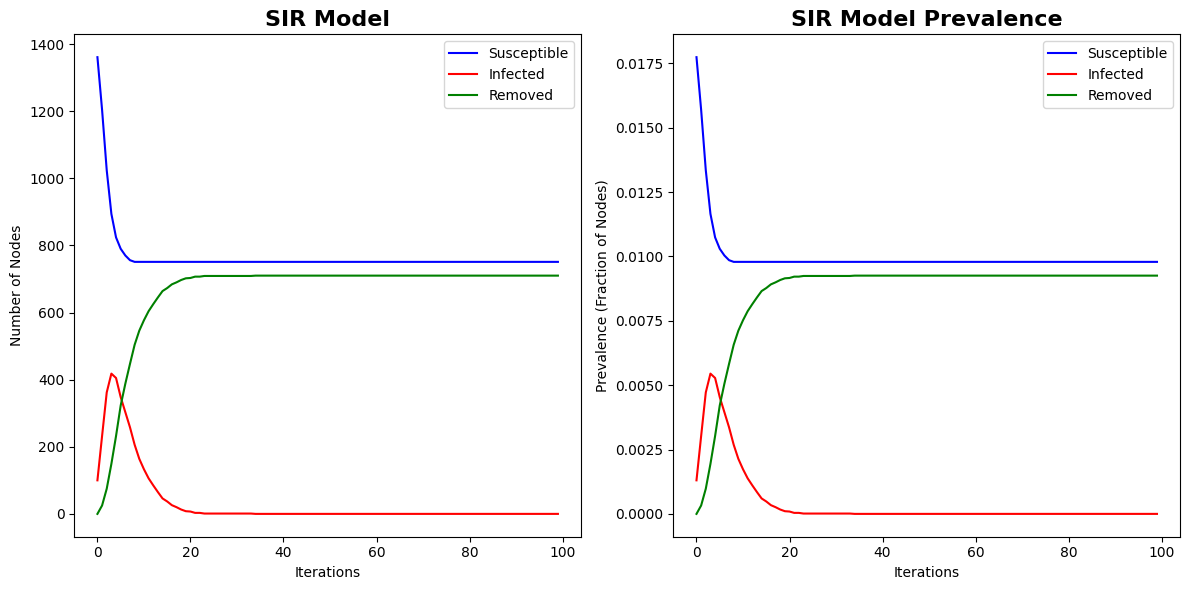

In [100]:
infection = 0.5
removal = 0.2
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(infection, removal))
SIR_model(G, initial_infected_number, infection, removal, num_iterations)

Running SIR model simulation for 0.3 infection probability and 0.3 removal probability.


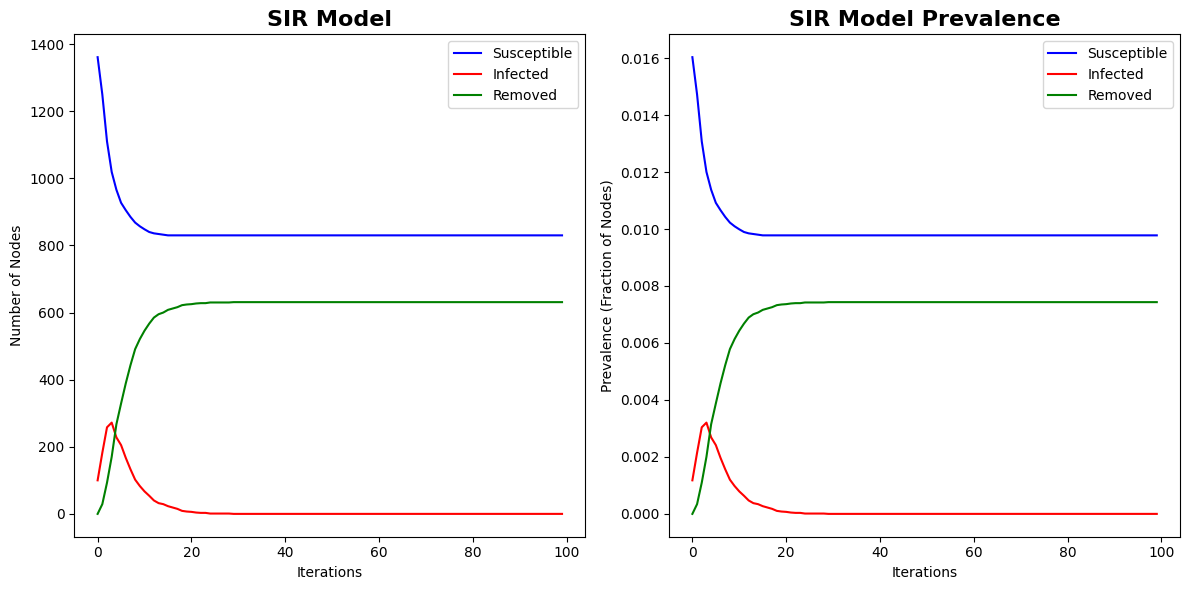

In [101]:
infection = 0.3
removal = 0.3
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(infection, removal))
SIR_model(G, initial_infected_number, infection, removal, num_iterations)

Running SIR model simulation for 0.4 infection probability and 0.5 removal probability.


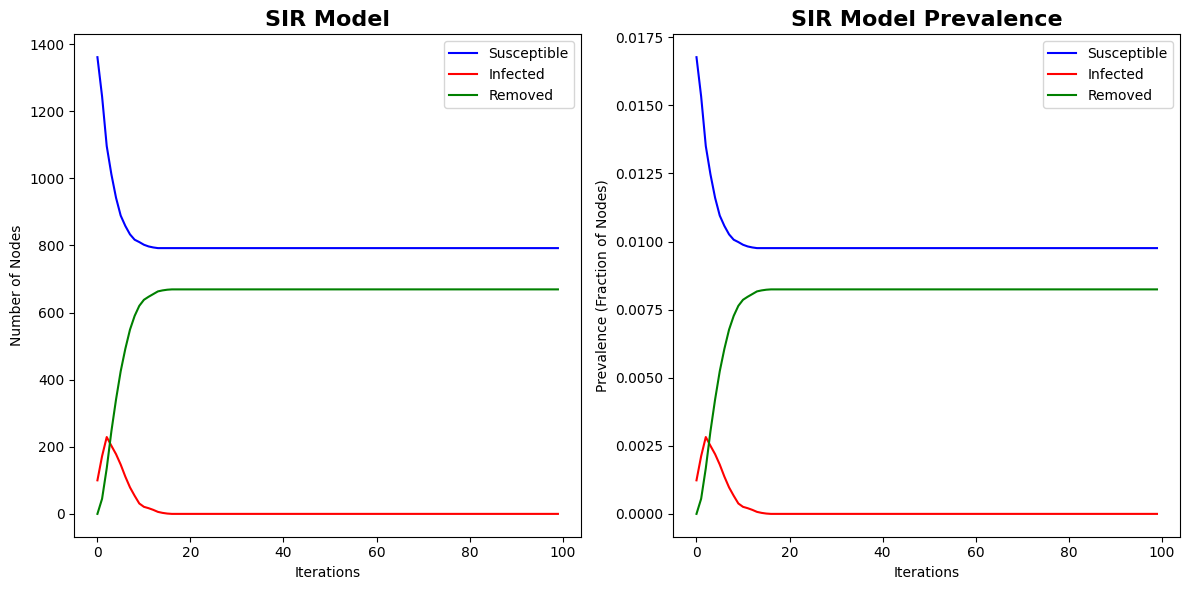

In [102]:
infection = 0.4
removal = 0.5
print("Running SIR model simulation for {0} infection probability and {1} removal probability.".format(infection, removal))
SIR_model(G, initial_infected_number, infection, removal, num_iterations)